In [1]:
%load_ext autoreload
%autoreload 2

In [76]:
# !joblib==0.13.2            # via scikit-learn
# !numpy==1.17.0
# !scikit-learn==0.21.3
# !pip install scikit-learn==0.22
# !scipy=:=1.3.1              # via scikit-learn
# !coverage==4.5.4
# !matplotlib==3.1.1
# !git clone https://github.com/nla-group/ABBA.git
# !pip install sktime

In [3]:
import os
os.environ["OMP_NUM_THREADS"] = '1'

https://arxiv.org/pdf/2003.05672.pdf

https://github.com/nla-group/ABBA-LSTM/blob/master/paper/UCRArchive/batchlessLSTM_pytorch/UCRArchive.py


In [28]:
from ABBA import ABBA
from sktime.datasets import load_UCR_UEA_dataset
from sktime.datatypes import convert_to
from sklearn.preprocessing import MinMaxScaler
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm
import torch.nn.functional as F
from tslearn.metrics import dtw as dtw
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def sMAPE(A, F):
    smape = 100/len(A) * torch.sum(2 * torch.abs(A - F) / (torch.abs(A) + torch.abs(F)))
    return smape.item()

In [5]:
# ts = [-1, 0.1, 1.3, 2, 1.9, 2.4, 1.8, 0.8, -0.5]
# abba = ABBA()
# string, centers = abba.transform(ts)

# reconstructed_ts = abba.inverse_transform(string, centers, ts[0])
# print([round(i, 1) for i in reconstructed_ts])
# # [-1, 0.1, 1.3, 1.9, 1.5, 2.1, 1.8, 0.6, -0.5]

In [32]:
x=torch.rand(10)
y=torch.rand(10)
sMAPE(x,y),dtw(x,y)

(70.8698959350586, 0.6551550196306344)

In [6]:
def define_dataset(name = "SwedishLeaf",scaler=True):
   #"DistalPhalanxOutlineAgeGroup"
  X_train, y_train = load_UCR_UEA_dataset(name=name,split="train", return_X_y=True)
  X_test, y_test = load_UCR_UEA_dataset(name=name,split="test", return_X_y=True)

  X_train = convert_to(X_train, to_type=["numpy3D"])[:,0,:]
  X_test = convert_to(X_test, to_type=["numpy3D"])[:,0,:]

  y_train=y_train.astype(int)
  y_test=y_test.astype(int)

  X, y = load_UCR_UEA_dataset(name=name,split=None, return_X_y=True)
  X_n = convert_to(X, to_type=["numpy3D"])[:,0,:]

  if scaler:
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaler.fit(X_n)
    # print(scaler.data_max_)
    X_train=scaler.transform(X_train)
    X_test=scaler.transform(X_test)
  X_train = torch.tensor(X_train)
  X_test = torch.tensor(X_test)
  return X_train,X_test,y_train,y_test

small_dataset=['ACSF1',
 'Adiac',
 'ArrowHead',
 'Beef',
 'BeetleFly',
 'BirdChicken',
 'BME',
 'Car',
 'CBF',
 'Chinatown',
 'ChlorineConcentration',
 'CinCECGTorso',
 'Coffee',
 'Computers',
 'CricketX',
 'CricketY',
 'CricketZ',
 'DiatomSizeReduction',
 'DistalPhalanxOutlineCorrect',
 'DistalPhalanxOutlineAgeGroup',
 'DistalPhalanxTW',
 'DodgerLoopDay',
 'DodgerLoopGame',
 'DodgerLoopWeekend',
 'Earthquakes',
 'ECG200',
 'ECG5000',
 'ECGFiveDays',
 'EOGHorizontalSignal',
 'EOGVerticalSignal',
 'EthanolLevel',
 'FaceAll',
 'FaceFour',
 'FacesUCR',
 'FiftyWords',
 'Fish',
 'FreezerRegularTrain',
 'FreezerSmallTrain',
 'Fungi',
 'GunPoint',
 'GunPointAgeSpan',
 'GunPointMaleVersusFemale',
 'GunPointOldVersusYoung',
 'Ham',
 'Herring',
 'InsectEPGRegularTrain',
 'InsectWingbeatSound',
 'LargeKitchenAppliances',
 'Lightning2',
 'Lightning7',
 'Mallat',
 'Meat',
 'MedicalImages',
 'MiddlePhalanxOutlineCorrect',
 'MiddlePhalanxOutlineAgeGroup',
 'MiddlePhalanxTW',
 'MixedShapesRegularTrain',
 'MixedShapesSmallTrain',
 'MoteStrain',
 'OSULeaf',
 'Phoneme',
 'PigAirwayPressure',
 'PigArtPressure',
 'PigCVP',
 'Plane',
 'PowerCons',
 'ProximalPhalanxOutlineCorrect',
 'ProximalPhalanxOutlineAgeGroup',
 'ProximalPhalanxTW',
 'RefrigerationDevices',
 'Rock',
 'ScreenType',
 'SemgHandGenderCh2',
 'SemgHandMovementCh2',
 'SemgHandSubjectCh2',
 'ShapeletSim',
 'ShapesAll',
 'SmallKitchenAppliances',
 'SmoothSubspace',
 'SonyAIBORobotSurface1',
 'SonyAIBORobotSurface2',
 'SwedishLeaf',
 'Symbols',
 'SyntheticControl',
 'ToeSegmentation1',
 'ToeSegmentation2',
 'Trace',
 'TwoLeadECG',
 'UMD',
 'Wine',
 'WordSynonyms',
 'Worms',
 'WormsTwoClass']  

In [7]:
name=small_dataset[0]
X_train,X_test,y_train,y_test = define_dataset(name = name,scaler=False)

In [234]:
list_dataset=[]
shape_list=[]
for name in tqdm(small_dataset):
    X_train,X_test,y_train,y_test = define_dataset(name = name,scaler=False)
    shape_list.append(X_train.shape[1])
    if X_train.shape[1]>800:
        print(name,X_train.shape)
        list_dataset.append(name)
    


  1%|          | 1/93 [00:02<04:02,  2.63s/it]

ACSF1 torch.Size([100, 1460])


 14%|█▍        | 13/93 [00:34<07:13,  5.42s/it]

CinCECGTorso torch.Size([40, 1639])


 31%|███       | 29/93 [01:04<03:54,  3.66s/it]

EOGHorizontalSignal torch.Size([362, 1250])


 32%|███▏      | 30/93 [01:12<05:03,  4.82s/it]

EOGVerticalSignal torch.Size([362, 1250])


 33%|███▎      | 31/93 [01:30<08:49,  8.54s/it]

EthanolLevel torch.Size([504, 1751])


 55%|█████▍    | 51/93 [02:45<06:03,  8.64s/it]

Mallat torch.Size([55, 1024])


 61%|██████▏   | 57/93 [03:18<05:59,  9.99s/it]

MixedShapesRegularTrain torch.Size([500, 1024])


 62%|██████▏   | 58/93 [03:43<08:28, 14.53s/it]

MixedShapesSmallTrain torch.Size([100, 1024])


 66%|██████▌   | 61/93 [04:07<06:17, 11.79s/it]

Phoneme torch.Size([214, 1024])


 67%|██████▋   | 62/93 [04:13<05:10, 10.00s/it]

PigAirwayPressure torch.Size([104, 2000])


 68%|██████▊   | 63/93 [04:19<04:24,  8.81s/it]

PigArtPressure torch.Size([104, 2000])


 69%|██████▉   | 64/93 [04:25<03:49,  7.93s/it]

PigCVP torch.Size([104, 2000])


 76%|███████▋  | 71/93 [04:36<01:00,  2.77s/it]

Rock torch.Size([20, 2844])


 78%|███████▊  | 73/93 [04:55<02:12,  6.61s/it]

SemgHandGenderCh2 torch.Size([300, 1500])


 80%|███████▉  | 74/93 [05:09<02:46,  8.75s/it]

SemgHandMovementCh2 torch.Size([450, 1500])


 81%|████████  | 75/93 [05:22<03:02, 10.12s/it]

SemgHandSubjectCh2 torch.Size([450, 1500])


 99%|█████████▉| 92/93 [05:55<00:01,  1.77s/it]

Worms torch.Size([181, 900])


100%|██████████| 93/93 [05:58<00:00,  3.85s/it]

WormsTwoClass torch.Size([181, 900])


In [332]:
list_dataset=['ACSF1',
 'CinCECGTorso',
 'EOGHorizontalSignal',
 'EOGVerticalSignal',
 'EthanolLevel',
 'Mallat',
 'MixedShapesRegularTrain',
 'MixedShapesSmallTrain',
 'Phoneme',
 'PigAirwayPressure',
 'PigArtPressure',
 'PigCVP',
 'Rock',
 'SemgHandGenderCh2',
 'SemgHandMovementCh2',
 'SemgHandSubjectCh2',
 'Worms',
 'WormsTwoClass']

  0%|          | 0/18 [00:00<?, ?it/s]

ACSF1 torch.Size([100, 1460])


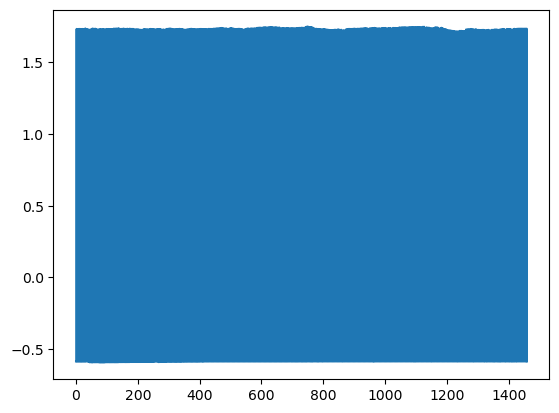

  6%|▌         | 1/18 [00:02<00:46,  2.74s/it]

CinCECGTorso torch.Size([40, 1639])


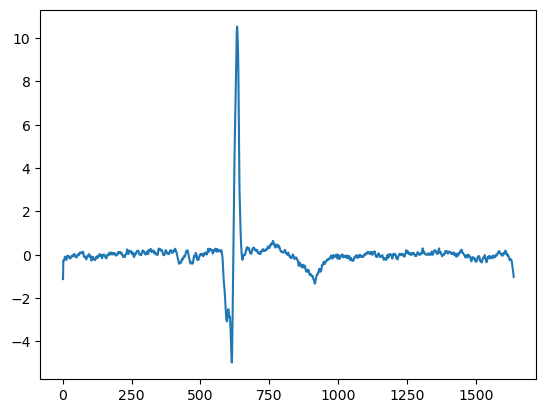

 22%|██▏       | 4/18 [00:38<02:12,  9.48s/it]

EthanolLevel torch.Size([504, 1751])


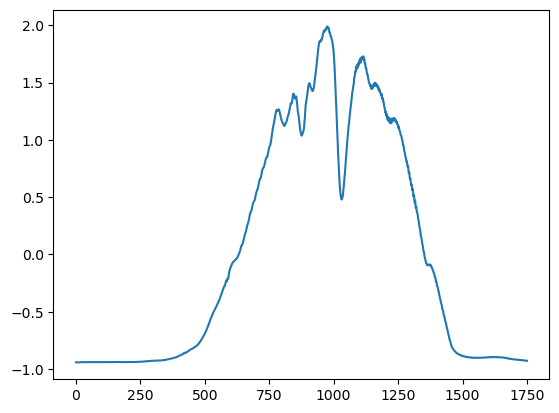

 50%|█████     | 9/18 [02:21<02:53, 19.31s/it]

PigAirwayPressure torch.Size([104, 2000])


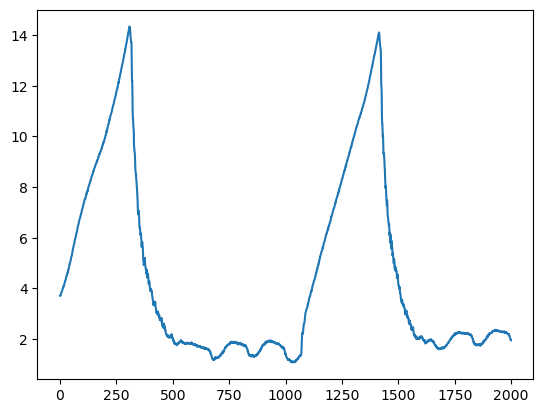

 56%|█████▌    | 10/18 [02:26<02:00, 15.02s/it]

PigArtPressure torch.Size([104, 2000])


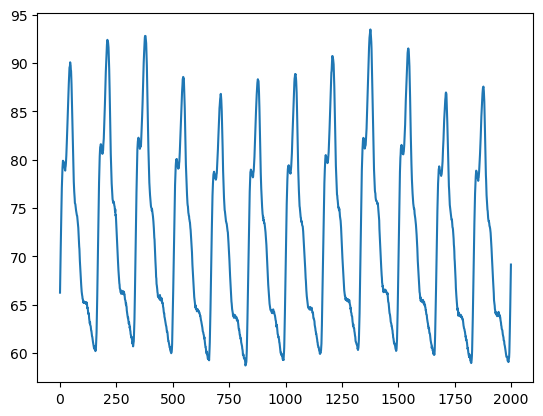

 61%|██████    | 11/18 [02:31<01:24, 12.09s/it]

PigCVP torch.Size([104, 2000])


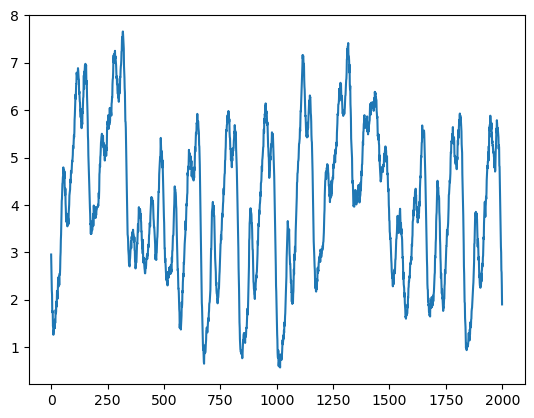

 67%|██████▋   | 12/18 [02:37<01:00, 10.06s/it]

Rock torch.Size([20, 2844])


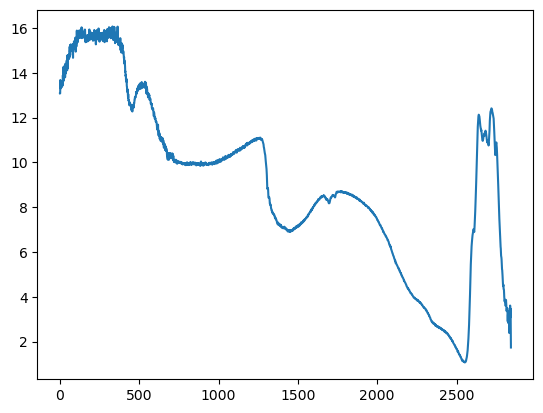

 72%|███████▏  | 13/18 [02:39<00:37,  7.57s/it]

SemgHandGenderCh2 torch.Size([300, 1500])


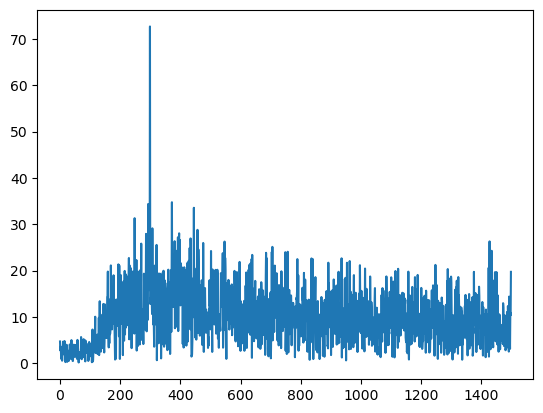

 78%|███████▊  | 14/18 [02:50<00:34,  8.74s/it]

SemgHandMovementCh2 torch.Size([450, 1500])


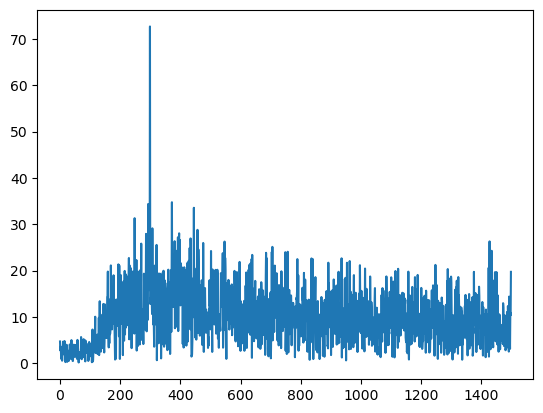

 83%|████████▎ | 15/18 [03:02<00:28,  9.63s/it]

SemgHandSubjectCh2 torch.Size([450, 1500])


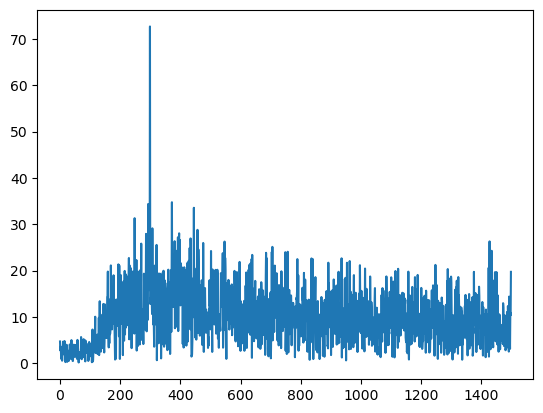

100%|██████████| 18/18 [03:18<00:00, 11.01s/it]


In [339]:
big_dataset=[]
shape_list=[]
for name in tqdm(list_dataset):
    X_train,X_test,y_train,y_test = define_dataset(name = name,scaler=False)
    shape_list.append(X_train.shape[1])
    if X_train.shape[1]>1400:
        print(name,X_train.shape)
        big_dataset.append(name)
        plt.plot(X_train[0])
        plt.show()
    

In [337]:
n_size=1400
(np.array(shape_list)>=n_size).sum()

10

In [341]:
big_dataset=['ACSF1',
 'CinCECGTorso',
 'EthanolLevel',
 'PigAirwayPressure',
 'PigArtPressure',
 'PigCVP',
 'Rock',
 'SemgHandGenderCh2',
 'SemgHandMovementCh2',
 'SemgHandSubjectCh2']

# visualizing some expereiments

In [ ]:
# # error in function of the length of alphabet
# l_error=[]
# l_maxk=[i for i in range(2,40)]
# for max_k in tqdm(l_maxk):
#     # max_k=10
#     tol=0.05
#     abba = ABBA(tol=tol, scl=0, min_k=2, max_k=max_k, verbose=0)

#     # for i in tqdm(range(X_train.shape[0])):
#     string, centers = abba.transform(ts)
#     reconstructed_ts = abba.inverse_transform(string, centers, ts[0])
#     reconstructed_ts= torch.tensor(reconstructed_ts)
#     error = F.mse_loss(reconstructed_ts,ts,reduction='mean')
#     l_error.append(error)
# plt.plot(l_maxk,l_error)

  0%|          | 0/38 [00:00<?, ?it/s]


AttributeError: 'list' object has no attribute 'size'

In [ ]:
# plot some signal and its reconstruction
tol=0.05
max_k=10
abba = ABBA(tol=tol, scl=0, min_k=2, max_k=max_k, verbose=0)
for i in range(100,len(ts),100):
    plt.plot(ts[i-100:i])
    plt.plot(reconstructed_ts[i-100:i])
    plt.legend(["ts","ts recon"])
    plt.show()

# data preparation

## Dataset preparation + ABBA tokenization into onehot

In [8]:
from torch.utils.data import Dataset, DataLoader
# create a pytorch dataset which extract random patch of one time series
class TimeSeriesDataset(Dataset):
    def __init__(self, ts, patch_size, predict_n_last,stateless=True,test=False):
        self.ts = ts
        self.patch_size = patch_size
        self.predict_n_last = predict_n_last
        self.stateless=stateless
        self.test=test
        
    def __len__(self):
        return len(self.ts) - self.patch_size - self.predict_n_last

    def __getitem__(self, idx):
        # extract a patch of the time series
        
        if self.test:
            last_patch_idx = idx + self.patch_size
            if self.stateless:
                ts_patch = self.ts[idx : last_patch_idx]
            else:
                ts_patch = self.ts[ : last_patch_idx]

        else:
            # sample a random patch of the time series
            random_idx = np.random.randint(0, len(self.ts) - self.patch_size - self.predict_n_last)
            last_patch_idx = random_idx+self.patch_size
            if self.stateless:
                ts_patch = self.ts[random_idx : last_patch_idx]
            else:
                ts_patch = self.ts[ : last_patch_idx]

        target = self.ts[last_patch_idx : last_patch_idx + self.predict_n_last]

        return ts_patch,target
    


class Tokeniser(nn.Module):
    def __init__(self, num_unique_characters):
        super(Tokeniser, self).__init__()
        self.num_unique_characters = num_unique_characters
        self.list_all_chr = [chr(97+i) for i in range(num_unique_characters)]
        self.char_to_index = {char: i for i, char in enumerate(self.list_all_chr)} #{char: i for i, char in enumerate(set(seq))}
        
    def forward(self, seq):
        one_hot = torch.zeros(( len(seq), self.num_unique_characters))
        for i, char in enumerate(seq):
            # Set the corresponding element in the one-hot encoded array to 1
            one_hot[i, self.char_to_index[char]] = 1
        return one_hot

    def return_dataset(self,ts_string_train,patch_size, predict_n_last):
        X_train_tok = self(ts_string_train)
        # X_test_tok = self(ts_string_test)
        
        # create Tensor datasets
        train_data = TimeSeriesDataset(X_train_tok, patch_size, predict_n_last)
        # test_data = TimeSeriesDataset(X_test_tok, patch_size, predict_n_last,test=True)
        return train_data,X_train_tok#,X_test_tok

## lstm and lstm abba

In [256]:
import torch
import torch.nn as nn
import copy
class LSTMModel(nn.Module):
    """
        lstm input format = (seq_len, bs, input_size)
        lstm output format = (seq_len, bs, hidden_size)
        trainloader_abba_lstm format = (bs, context_string_lstm, num_unique_characters) where context_string_lstm = seq_len
        trainloader_raw_lstm format = (bs, context_raw_lstm) where context_raw_lstm = seq_len

    """
    def __init__(self, input_size, hidden_size, num_layers, output_size,abba=False,abba_model=None,gru=False):
        super(LSTMModel, self).__init__()
        self.gru_mode = gru
        self.abba_model= abba_model
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        if self.gru_mode:
            self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=False,dropout =0.2)
        else:
            self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=False,dropout =0.2)
            
        self.fc = nn.Linear(hidden_size, output_size)
        self.abba = abba
        


    def forward(self, x):
        if self.abba:
            #x = (bs, context_string_lstm, num_unique_characters)
            x=x.permute(1,0,2) 
        else:
            # x = (bs, context_raw_lstm)
            x=x.unsqueeze(-1) #  (bs, context_raw_lstm, 1)
            x=x.permute(1,0,2) #  (context_raw_lstm, bs, 1)
        if self.gru_mode:
            h0 = torch.zeros(self.num_layers, x.size(1), self.hidden_size).to(x.device)
            out, _ = self.gru(x, h0)
        else:
            h0 = torch.zeros(self.num_layers, x.size(1), self.hidden_size).to(x.device)
            c0 = torch.zeros(self.num_layers, x.size(1), self.hidden_size).to(x.device)
            out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[ :,:, :]) #self.fc(out[ -1,:, :])
        # average pooling
        
        out = torch.mean(out, dim=0)
        if self.abba:
            if len(out.shape)!=3:
                out = out.unsqueeze(1)
        return out

    def forecast(self,context_4_forcast, test_ts,ts_string_train=None,ts=None,centers=None):
        if self.abba:
            # forcast function abba lstm
            context = context_4_forcast
            all_predictions = torch.tensor([]).to(device)
            for _ in range(len(test_ts)+1):
                out = self(context)
                new_context = torch.cat((context[:,1:], out), dim=1) 
                context = new_context
                all_predictions = torch.cat((all_predictions, out), dim=1)
            argmax_pred= all_predictions.argmax(-1).squeeze().cpu()
            pred_seq=""
            for seq_i in argmax_pred:
                pred_seq+=chr(97+seq_i)

            full_seq = ts_string_train+pred_seq
            reconstructed_ts_part = self.abba_model.inverse_transform(full_seq, centers, ts[0])
            reconstructed_ts_part=reconstructed_ts_part[:len(ts)]
            return reconstructed_ts_part[-len(test_ts):]

        else:
            context_4_raw_test=context_4_forcast.unsqueeze(0).to(device)
            context = context_4_raw_test
            all_predictions = torch.tensor([]).to(device)
            for i in range(len(test_ts)):
                out = self(context)
                new_context = torch.cat((context[:,1:], out), dim=1) 
                context = new_context
                all_predictions = torch.cat((all_predictions, out), dim=1)

            return all_predictions


# Training loop
def train(model, optimizer, criterion, train_loader, device):
    model.train()
    train_loss = 0
    train_correct = 0
    for i, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        # scheduler.step()
        train_loss += loss.item()
        # train_correct += (predicted == targets).sum().item()
    # train_acc = 100 * train_correct / len(train_loader.dataset)
    return train_loss/len(train_loader)#, train_acc

# Testing loop
def test(model, context_4_raw_test, test_ts, criterion,plot_=False):
    model.eval()
    with torch.no_grad():
        prediction= model.forecast(context_4_raw_test,test_ts)
        prediction = prediction.squeeze()
        loss = criterion(prediction, test_ts.to(device))
        test_loss = loss.item()
        smape = sMAPE(prediction.cpu(), test_ts.cpu())
        dtw_value = dtw(prediction.cpu(), test_ts.cpu())
        test_loss = loss.item()
        metrics = [test_loss,smape,dtw_value]
        
        if plot_:
            plt.plot(test_ts,alpha=0.7)
            plt.plot(prediction.cpu(),alpha=0.7)
            if model.gru_mode:
                plt.title("sample test prediction vs ground truth raw gru")
            else:
                plt.title("sample test prediction vs ground truth raw lstm")
            plt.legend(["Ground truth","prediction"])
            plt.show()

        # test_correct += (predicted == targets).sum().item()
    # test_acc = 100 * test_correct / len(test_loader.dataset)
    return test_loss,metrics#, test_acc

def test_abba(model, context_4_raw_test,test_ts,criterion,ts_string_train,ts,centers,plot_=False):
    model.eval()
    test_loss = 0
    test_correct = 0
    with torch.no_grad():
        prediction= model.forecast(context_4_raw_test,test_ts,ts_string_train=ts_string_train,ts=ts,centers=centers)
        prediction = torch.tensor(prediction).squeeze()
        loss = criterion(prediction, test_ts)
        smape = sMAPE(prediction, test_ts)
        dtw_value = dtw(prediction.cpu(), test_ts.cpu())
        test_loss = loss.item()

        metrics = [test_loss,smape,dtw_value]
        if plot_:
            plt.plot(test_ts,alpha=0.7)
            plt.plot(prediction,alpha=0.7)
            if model.gru_mode:
                plt.title("sample test prediction vs ground truth ABBA gru")
            else:
                plt.title("sample test prediction vs ground truth ABBA lstm")
            plt.legend(["Ground truth","prediction"])
            plt.show()
    return test_loss,metrics#, test_acc

## fit function

In [315]:
def fit_raw_lstm(trainloader_raw_lstm,context_4_raw_test, ts_raw_test,gru =False):
    plot_=True
    input_size = 1
    hidden_size = 32
    num_layers = 2
    learning_rate = 5e-3
    num_epochs = 100
    output_size = 1
    best_loss = 1000000000
    # Instantiate the model
    model = LSTMModel(input_size, hidden_size, num_layers, output_size, gru = gru).to(device)

    # Define the loss function and optimizer
    criterion = nn.MSELoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=0.01)
    # scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=learning_rate, steps_per_epoch=len(trainloader_raw_lstm), epochs=num_epochs)
    # all_metrics = torch.tensor([])
    # Train the model
    for epoch in range(1,1+num_epochs):
        train_loss = train(model, optimizer , criterion, trainloader_raw_lstm, device)
        # if epoch in [50,70,80,90]:
        #     plot_=True
        # else:
        plot_=False
        test_loss,metrics = test(model, context_4_raw_test, ts_raw_test, criterion,plot_=plot_)
        if metrics[0]<best_loss:
            best_loss = test_loss
            best_model = copy.deepcopy(model)
        
        # print(f'Epoch {epoch+1}: Train Loss = {train_loss:.4f}, Train Acc = {train_acc:.2f}%, Test Loss = {test_loss:.4f}, Test Acc = {test_acc:.2f}%')
        # if epoch in [95,98,99]:

            # print(f'Raw lstm Epoch {epoch+1}: Train Loss = {train_loss:.4f}, Test Loss = {test_loss:.4f}')
    model=best_model
    test_loss,metrics = test(model, context_4_raw_test, ts_raw_test, criterion,plot_=True)
    if gru:
        print(f'Raw gru final Epoch {epoch+1}: Train Loss = {train_loss:.4f}, Test Loss = {test_loss:.4f}')
    else:
        print(f'Raw lstm final Epoch {epoch+1}: Train Loss = {train_loss:.4f}, Test Loss = {test_loss:.4f}')
    return metrics
    # with torch.no_grad():
    #     prediction= model.forecast(context_4_raw_test,ts_raw_test)
    # plt.plot(prediction.cpu().numpy().flatten(),label='prediction')
    # plt.plot(ts_raw_test.cpu().numpy().flatten(),label='ground true')
    # plt.legend()
    # plt.show()

In [316]:
def fit_abba_lstm(trainloader_abba_lstm,num_unique_characters,abba,context_4_abba_test,ts_raw_test,ts_string_train,ts_norm,centers,gru=False):
    input_size = num_unique_characters
    hidden_size = 32
    num_layers = 2
    learning_rate = 5e-3
    num_epochs = 200
    output_size = num_unique_characters
    test_loss=0
    best_loss=1000000000
    model = LSTMModel(input_size, hidden_size, num_layers, output_size,abba=True,abba_model=abba,gru=gru).to(device)
    # all_metrics = torch.tensor([])
    # Define the loss function and optimizer
    criterion = nn.MSELoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=0.01)
    # scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=learning_rate, steps_per_epoch=len(trainloader_abba_lstm), epochs=num_epochs)
    # Train the model
    for epoch in range(1,1+num_epochs):
        # if epoch in [100,150,180]:
        #     plot_=True
        # else:
        plot_=False
        train_loss = train(model, optimizer, criterion, trainloader_abba_lstm, device)
        test_loss,metrics = test_abba(model, context_4_abba_test,ts_raw_test,criterion,ts_string_train=ts_string_train,ts=ts_norm,centers=centers,plot_=plot_)
        # all_metrics = torch.cat((all_metrics,metrics),0)
        # if epoch in [150,198,200]:
        #     print(f'Abba Epoch {epoch+1}: Train Loss = {train_loss:.4f}, Test Loss = {test_loss:.4f}')
        if metrics[0]<best_loss:
            best_loss = test_loss
            best_model = copy.deepcopy(model)
    model=best_model
    test_loss,metrics = test_abba(model, context_4_abba_test,ts_raw_test,criterion,ts_string_train=ts_string_train,ts=ts_norm,centers=centers,plot_=True)
    if gru:
        print(f'Abba gru final Epoch {epoch+1}: Train Loss = {train_loss:.4f}, Test Loss = {test_loss:.4f}')
    else:
        print(f'Abba lstm final Epoch {epoch+1}: Train Loss = {train_loss:.4f}, Test Loss = {test_loss:.4f}')
    return metrics


In [262]:
ts.shape

torch.Size([600])

In [259]:
num_unique_characters=10
tol=0.05
context_raw_lstm=40
context_string_lstm=5
predict_n_last_values=1
bs = 32
predict_n_last_characters=200
ts = X_train[33][:600]
ts_train = ts[:-predict_n_last_characters]
# ts_test = ts[-predict_n_last_characters:]
# normalise X_sample
mean = ts_train.mean()
std = ts_train.std()
ts_norm = (ts-mean) / std
ts_train_norm = ts_norm[:-predict_n_last_characters]
ts_test_norm = ts_norm[-predict_n_last_characters:]
#define ABBA

abba = ABBA(tol=tol, scl=0, min_k=2, max_k=num_unique_characters, verbose=0)
#ABBA transform
string, centers = abba.transform(ts_train_norm)
num_unique_characters=len(centers)
#check reconstruction
reconstructed_ts = torch.tensor(abba.inverse_transform(string, centers, ts_train_norm[0]))
error= F.mse_loss(reconstructed_ts,ts_train_norm,reduction='mean')
print("reconstruction error = ", error.item())

# forecast the last n characters for testing
len_train_string_ts=len(string) - predict_n_last_characters
# compute the length of the reconstructed truncated time series to have the same amount of data to predict for the raw time series and string (abba) time series

reconstructed_ts_train = abba.inverse_transform(string[:len_train_string_ts], centers, ts_norm[0])
len_train_raw_ts=len(reconstructed_ts_train)

# dataset split between train and test
ts_norm=ts_norm.float()
ts_string_train = string
ts_raw_train = ts_train_norm.float()
ts_raw_test = ts_test_norm.float()

# context 2 forcast whole raw test set
context_4_raw_test=ts_raw_train[-context_raw_lstm:]




# create pytorch dataset and dataloader for raw lstm
trainset_raw_lstm=TimeSeriesDataset(ts_raw_train, context_raw_lstm, predict_n_last_values)
# testset_raw_lstm=TimeSeriesDataset(ts_raw_test, context_raw_lstm, predict_n_last_values,test=True)

trainloader_raw_lstm = DataLoader(trainset_raw_lstm, batch_size=bs,
                        shuffle=True)            
# testloader_raw_lstm = DataLoader(testset_raw_lstm, batch_size=bs*4,
#                         shuffle=False)    

# create pytorch dataset and dataloader for string lstm
tok = Tokeniser(num_unique_characters)
train_data,x_train_tok=tok.return_dataset(ts_string_train, context_string_lstm, predict_n_last_values)
context_4_abba_test=x_train_tok[-context_string_lstm:].unsqueeze(0).to(device)

trainloader_abba_lstm = DataLoader(train_data, batch_size=bs,
                        shuffle=True)            


test4lstm = fit_raw_lstm(trainloader_raw_lstm,context_4_raw_test, ts_raw_test)

test4gru = fit_raw_lstm(trainloader_raw_lstm,context_4_raw_test, ts_raw_test,gru=True)

test4abba_lstm = fit_abba_lstm(trainloader_abba_lstm,num_unique_characters,abba,context_4_abba_test,ts_raw_test,ts_string_train,ts_norm,centers)
test4abba_gru = fit_abba_lstm(trainloader_abba_lstm,num_unique_characters,abba,context_4_abba_test,ts_raw_test,ts_string_train,ts_norm,centers,gru=True)

reconstruction error =  2.185399607772272


IndexError: index -1 is out of bounds for axis 0 with size 0

In [251]:
list_dataset

['ACSF1',
 'CinCECGTorso',
 'EOGHorizontalSignal',
 'EOGVerticalSignal',
 'EthanolLevel',
 'Mallat',
 'MixedShapesRegularTrain',
 'MixedShapesSmallTrain',
 'Phoneme',
 'PigAirwayPressure',
 'PigArtPressure',
 'PigCVP',
 'Rock',
 'SemgHandGenderCh2',
 'SemgHandMovementCh2',
 'SemgHandSubjectCh2',
 'Worms',
 'WormsTwoClass']

In [269]:
len_train_string_ts

-138

  0%|          | 0/10 [00:00<?, ?it/s]

dataset  ACSF1
reconstruction error =  0.09104895962094726


c:\Users\lejuj\anaconda3\envs\torch\lib\site-packages\torch\nn\modules\rnn.py:812: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\cudnn\RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


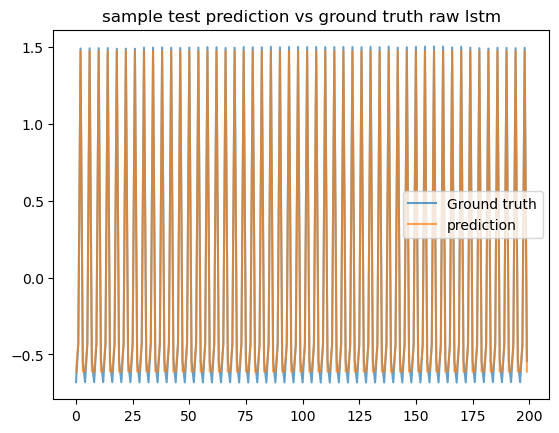

Raw lstm final Epoch 101: Train Loss = 0.4099, Test Loss = 0.0026


c:\Users\lejuj\anaconda3\envs\torch\lib\site-packages\torch\nn\modules\rnn.py:998: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\cudnn\RNN.cpp:982.)
  result = _VF.gru(input, hx, self._flat_weights, self.bias, self.num_layers,


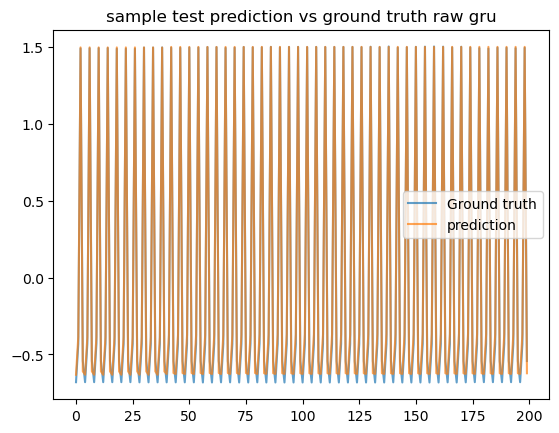

Raw gru final Epoch 101: Train Loss = 0.3748, Test Loss = 0.0031


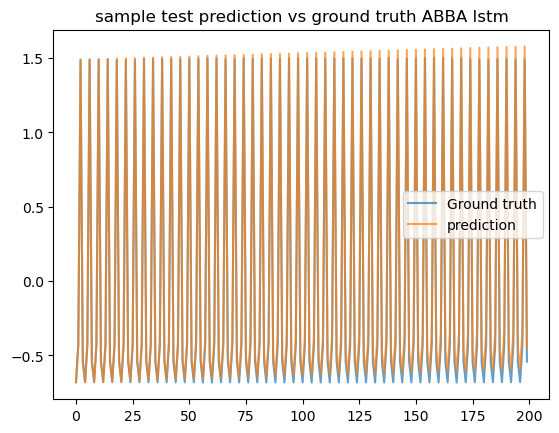

Abba lstm final Epoch 201: Train Loss = 0.0009, Test Loss = 0.0026


In [342]:
# function to test on one full dataset

# hyperparameters
num_unique_characters=10
tol=0.05
context_raw_lstm=40
context_string_lstm=5
predict_n_last_values=1
bs = 32 


l_datastet_test=[]
predict_n_last_characters = 200
for name in tqdm(big_dataset):
    l_test4abba_lstm, l_test4abba_gru, l_test4lstm, l_test4gru=[],[],[],[]

    print("============================================")
    print("============================================")
    print("dataset ",name)
    X_train,X_test,y_train,y_test = define_dataset(name = name,scaler=False)

    idx = [i for i in range(len(X_train))]
    liste_idx=np.random.choice(idx, min(10,len(X_train)), replace=False)
    # extract the first element of dataset /!\ here we only use one time series need a for loop to use all time series
    count =0
    for i in liste_idx:
        print("==================")
        ts = X_train[i][:1200]
        ts_train = ts[:-predict_n_last_characters]
        # ts_test = ts[-predict_n_last_characters:]
        # normalise X_sample
        mean = ts_train.mean()
        std = ts_train.std()
        ts_norm = (ts-mean) / std
        ts_train_norm = ts_norm[:-predict_n_last_characters]
        ts_test_norm = ts_norm[-predict_n_last_characters:]
        #define ABBA

        abba = ABBA(tol=tol, scl=0, min_k=2, max_k=num_unique_characters, verbose=0)
        #ABBA transform
        string, centers = abba.transform(ts_train_norm)
        num_unique_characters=len(centers)
        #check reconstruction
        reconstructed_ts = torch.tensor(abba.inverse_transform(string, centers, ts_train_norm[0]))
        error= F.mse_loss(reconstructed_ts,ts_train_norm,reduction='mean')
        print("reconstruction error = ", error.item())

        # forecast the last n characters for testing
        len_train_string_ts=len(string) - predict_n_last_characters
        # compute the length of the reconstructed truncated time series to have the same amount of data to predict for the raw time series and string (abba) time series

        reconstructed_ts_train = abba.inverse_transform(string[:-len_train_string_ts], centers, ts_norm[0])
        len_train_raw_ts=len(reconstructed_ts_train)

        # dataset split between train and test
        ts_norm=ts_norm.float()
        ts_string_train = string
        ts_raw_train = ts_train_norm.float()
        ts_raw_test = ts_test_norm.float()

        # context 2 forcast whole raw test set
        context_4_raw_test=ts_raw_train[-context_raw_lstm:]




        # create pytorch dataset and dataloader for raw lstm
        trainset_raw_lstm=TimeSeriesDataset(ts_raw_train, context_raw_lstm, predict_n_last_values)
        # testset_raw_lstm=TimeSeriesDataset(ts_raw_test, context_raw_lstm, predict_n_last_values,test=True)

        trainloader_raw_lstm = DataLoader(trainset_raw_lstm, batch_size=bs,
                                shuffle=True)            
        # testloader_raw_lstm = DataLoader(testset_raw_lstm, batch_size=bs*4,
        #                         shuffle=False)    

        # create pytorch dataset and dataloader for string lstm
        tok = Tokeniser(num_unique_characters)
        train_data,x_train_tok=tok.return_dataset(ts_string_train, context_string_lstm, predict_n_last_values)
        context_4_abba_test=x_train_tok[-context_string_lstm:].unsqueeze(0).to(device)

        trainloader_abba_lstm = DataLoader(train_data, batch_size=bs,
                                shuffle=True)            
        

        test4lstm = fit_raw_lstm(trainloader_raw_lstm,context_4_raw_test, ts_raw_test)

        test4gru = fit_raw_lstm(trainloader_raw_lstm,context_4_raw_test, ts_raw_test,gru=True)

        test4abba_lstm = fit_abba_lstm(trainloader_abba_lstm,num_unique_characters,abba,context_4_abba_test,ts_raw_test,ts_string_train,ts_norm,centers)
        test4abba_gru = fit_abba_lstm(trainloader_abba_lstm,num_unique_characters,abba,context_4_abba_test,ts_raw_test,ts_string_train,ts_norm,centers,gru=True)

        l_test4abba_lstm.append(test4abba_lstm)
        l_test4abba_gru.append(test4abba_gru)
        l_test4lstm.append(test4lstm)
        l_test4gru.append(test4gru)
    l_datastet_test.append([l_test4abba_lstm,l_test4abba_gru,l_test4lstm,l_test4gru])

    # l_lstm_test=torch.tensor(l_lstm_test)
    # l_abba_test=torch.tensor(l_abba_test)

In [299]:
all_data = np.array(l_datastet_test)


In [301]:
all_data.shape

(5, 4, 5, 3)

In [319]:
all_data = np.array(l_datastet_test)
all_data.shape # shape =(nb_dataset,4 model,nb_ts,3 measures)  measures = [mse,sMAPE,dtw]
all_data_mean = all_data.mean(axis=2) # mean over all time series of each dataset independently

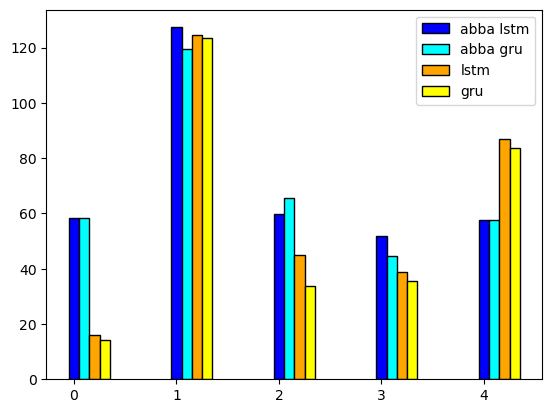

In [310]:
idx_metric=1

barWidth = 0.1

bars1 = all_data_mean[:,0,idx_metric]
bars2 = all_data_mean[:,1,idx_metric]
bars3 = all_data_mean[:,2,idx_metric]
bars4 = all_data_mean[:,3,idx_metric]
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
r4 = [x + barWidth for x in r3]
plt.bar(r1, bars1, width = barWidth, color = 'blue', edgecolor = 'black', capsize=7, label='abba lstm')
plt.bar(r2, bars2, width = barWidth, color = 'cyan', edgecolor = 'black', capsize=7, label='abba gru')
plt.bar(r3, bars3, width = barWidth, color = 'orange', edgecolor = 'black', capsize=7, label='lstm')

plt.bar(r4, bars4, width = barWidth, color = 'yellow', edgecolor = 'black', capsize=7, label='gru')
plt.legend()
# plt.xticks([r + barWidth for r in range(len(bars1))], list_dataset[:5])


In [312]:
import pandas as pd

In [326]:
idx_metric=0
df_0 = pd.DataFrame(dict(dataset_name=list_dataset[:len(all_data_mean)],
                  abba_lstm=all_data_mean[:,0,idx_metric],
                  abba_gru=all_data_mean[:,1,idx_metric],
                  lstm=all_data_mean[:,2,idx_metric],
                  gru=all_data_mean[:,3,idx_metric]))
idx_metric=1
df_1 = pd.DataFrame(dict(dataset_name=list_dataset[:len(all_data_mean)],
                  abba_lstm=all_data_mean[:,0,idx_metric],
                  abba_gru=all_data_mean[:,1,idx_metric],
                  lstm=all_data_mean[:,2,idx_metric],
                  gru=all_data_mean[:,3,idx_metric]))
idx_metric=2
df_2 = pd.DataFrame(dict(dataset_name=list_dataset[:len(all_data_mean)],
                  abba_lstm=all_data_mean[:,0,idx_metric],
                  abba_gru=all_data_mean[:,1,idx_metric],
                  lstm=all_data_mean[:,2,idx_metric],
                  gru=all_data_mean[:,3,idx_metric]))
                  

# print(df.to_latex(index=False))  


In [327]:
df_0


,dataset_name,abba_lstm,abba_gru,lstm,gru
0,ACSF1,0.540201,0.673890,0.001562,0.000922
1,CinCECGTorso,144.411948,118.966306,136.978545,138.156488
2,EOGHorizontalSignal,2.607011,11.186268,0.552898,0.837502
3,EOGVerticalSignal,3.609708,1.664182,1.140907,1.601557
4,EthanolLevel,31.457382,45.144403,135.500766,132.225926
5,Mallat,0.139741,0.128889,0.030567,0.023065
6,MixedShapesRegularTrain,0.827516,0.941256,0.967796,0.702594
7,MixedShapesSmallTrain,0.768151,1.180693,0.881851,0.904669
8,Phoneme,134.928060,146.964775,1.609427,1.639759


In [328]:
df_1

,dataset_name,abba_lstm,abba_gru,lstm,gru
0,ACSF1,56.090635,53.118491,4.361272,2.477633
1,CinCECGTorso,98.129254,106.845042,132.861823,134.818556
2,EOGHorizontalSignal,72.862469,95.103246,49.330071,50.605861
3,EOGVerticalSignal,52.450099,47.693913,48.389326,48.347356
4,EthanolLevel,32.715050,42.266742,87.538579,84.879492
5,Mallat,26.441333,23.439615,12.206097,9.718266
6,MixedShapesRegularTrain,94.406710,91.018798,103.910592,91.522575
7,MixedShapesSmallTrain,90.512609,96.391835,96.884462,101.361065
8,Phoneme,143.216931,144.032111,108.714162,117.103905


In [329]:
df_2

,dataset_name,abba_lstm,abba_gru,lstm,gru
0,ACSF1,6.574730,2.411932,0.465102,0.331579
1,CinCECGTorso,84.729332,71.856782,95.846668,95.240467
2,EOGHorizontalSignal,12.905011,31.539478,6.559663,8.609010
3,EOGVerticalSignal,14.356625,12.279790,9.814839,10.537744
4,EthanolLevel,54.794455,71.718087,164.168724,161.960471
5,Mallat,3.416267,3.560057,1.626879,1.573002
6,MixedShapesRegularTrain,9.311549,8.576581,7.529647,8.914076
7,MixedShapesSmallTrain,5.254742,9.636807,9.624943,9.570870
8,Phoneme,106.093625,100.412975,10.535366,11.489952


In [277]:
for idx in range(len(list_dataset[:2])):
    [l_test4abba_lstm,l_test4abba_gru,l_test4lstm,l_test4gru] = l_datastet_test[idx]


    barWidth = 0.3
    
    # Choose the height of the blue bars
    bars1 = [10, 9, 2]
    
    # Choose the height of the cyan bars
    bars2 = [10.8, 9.5, 4.5]
    
    # Choose the height of the error bars (bars1)
    yer1 = [0.5, 0.4, 0.5]
    
    # Choose the height of the error bars (bars2)
    yer2 = [1, 0.7, 1]
    
    # The x position of bars
    r1 = np.arange(len(bars1))
    r2 = [x + barWidth for x in r1]
    
    # Create blue bars
    plt.bar(r1, bars1, width = barWidth, color = 'blue', edgecolor = 'black', yerr=yer1, capsize=7, label='poacee')
    
    # Create cyan bars
    plt.bar(r2, bars2, width = barWidth, color = 'cyan', edgecolor = 'black', yerr=yer2, capsize=7, label='sorgho')
    
    # general layout
    plt.xticks([r + barWidth for r in range(len(bars1))], ['cond_A', 'cond_B', 'cond_C'])
    plt.ylabel('height')
    plt.legend()
    
    # Show graphic
    plt.show()

# idx_metric=0

# plt.scatter(l_lstm_test[:,idx_metric],l_abba_test[:,idx_metric],)
# x_ax=[0,max(l_lstm_test[:,idx_metric])]
# y_ax = [0,max(l_lstm_test[:,idx_metric])]
# plt.plot(x_ax,y_ax)
# plt.xlabel("raw lstm")
# plt.ylabel("abba lstm")
# plt.title("MSE lstm abba perform better than raw lstm "+str((l_lstm_test[:,idx_metric]>l_abba_test[:,idx_metric]).sum().item()) +"/"+str(len(l_lstm_test)))
# plt.show()
# print((l_lstm_test[:,idx_metric]<l_abba_test[:,idx_metric]).sum().item())
# idx_metric=1

# plt.scatter(l_lstm_test[:,idx_metric],l_abba_test[:,idx_metric],)
# x_ax=[0,max(l_lstm_test[:,idx_metric])]
# y_ax = [0,max(l_lstm_test[:,idx_metric])]
# plt.plot(x_ax,y_ax)
# plt.xlabel("raw lstm")
# plt.ylabel("abba lstm")
# plt.title("sMAPE lstm abba perform better than raw lstm "+str((l_lstm_test[:,idx_metric]>l_abba_test[:,idx_metric]).sum().item()) +"/"+str(len(l_lstm_test)))
# plt.show()
# print((l_lstm_test[:,idx_metric]<l_abba_test[:,idx_metric]).sum().item())

# idx_metric=2

# plt.scatter(l_lstm_test[:,idx_metric],l_abba_test[:,idx_metric],)
# x_ax=[0,max(l_lstm_test[:,idx_metric])]
# y_ax = [0,max(l_lstm_test[:,idx_metric])]
# plt.plot(x_ax,y_ax)
# plt.xlabel("raw lstm")
# plt.ylabel("abba lstm")
# plt.title("DTW lstm abba perform better than raw lstm "+str((l_lstm_test[:,idx_metric]>l_abba_test[:,idx_metric]).sum().item()) +"/"+str(len(l_lstm_test)))
# plt.show()
# print((l_lstm_test[:,idx_metric]<l_abba_test[:,idx_metric]).sum().item())



[[[[18.102163314819336, 156.66085815429688, 48.59300404389935],
   [644.4678344726562, 156.27734375, 348.72284072940766],
   [50.65986633300781, 129.48484802246094, 94.46941075417321],
   [0.5148219466209412, 57.840423583984375, 3.6601329386111314],
   [0.9771554470062256, 46.31831741333008, 4.712137578860926],
   [17.520549774169922, 106.1941909790039, 55.77717852368475],
   [0.859727144241333, 50.003211975097656, 9.584203641532607],
   [21.905813217163086, 118.01439666748047, 61.35907347908325],
   [5.700206279754639, 36.87656021118164, 26.538845192197975],
   [10.358553886413574, 85.73347473144531, 36.77927568216652],
   [2.1148183345794678, 52.130462646484375, 19.66296012262221],
   [0.5749183893203735, 46.31618118286133, 3.941717428164394],
   [22.600200653076172, 52.74800491333008, 51.87902600652921],
   [11.558505058288574, 97.75135040283203, 36.64946244547697],
   [0.007758375257253647, 2.379366397857666, 0.8788531261316543],
   [13.241911888122559, 125.72454833984375, 51.46138

In [ ]:
l_test4abba_lstm, l_test4abba_gru, l_test4lstm, l_test4gru, 

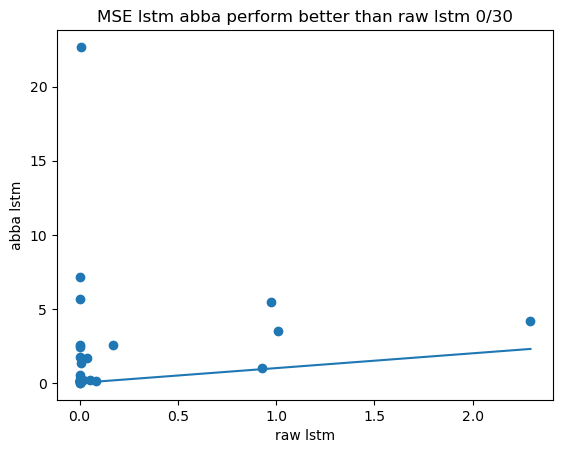

30


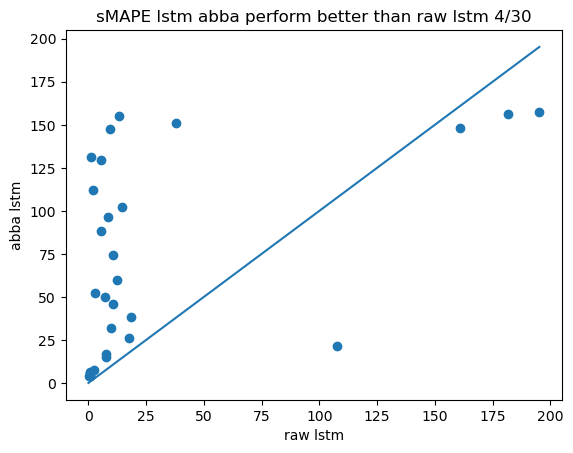

26


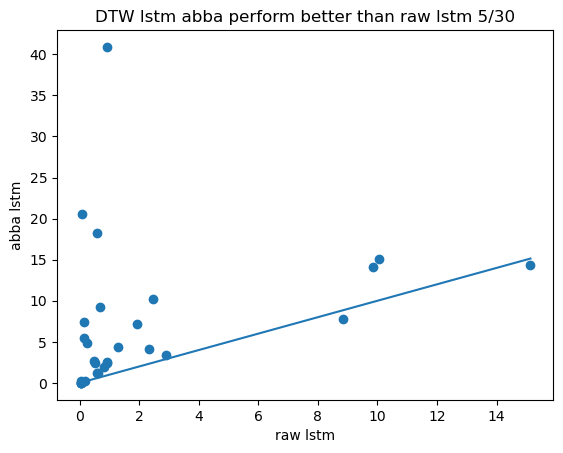

25


In [193]:
idx_metric=0

plt.scatter(l_lstm_test[:,idx_metric],l_abba_test[:,idx_metric],)
x_ax=[0,max(l_lstm_test[:,idx_metric])]
y_ax = [0,max(l_lstm_test[:,idx_metric])]
plt.plot(x_ax,y_ax)
plt.xlabel("raw lstm")
plt.ylabel("abba lstm")
plt.title("MSE lstm abba perform better than raw lstm "+str((l_lstm_test[:,idx_metric]>l_abba_test[:,idx_metric]).sum().item()) +"/"+str(len(l_lstm_test)))
plt.show()
print((l_lstm_test[:,idx_metric]<l_abba_test[:,idx_metric]).sum().item())
idx_metric=1

plt.scatter(l_lstm_test[:,idx_metric],l_abba_test[:,idx_metric],)
x_ax=[0,max(l_lstm_test[:,idx_metric])]
y_ax = [0,max(l_lstm_test[:,idx_metric])]
plt.plot(x_ax,y_ax)
plt.xlabel("raw lstm")
plt.ylabel("abba lstm")
plt.title("sMAPE lstm abba perform better than raw lstm "+str((l_lstm_test[:,idx_metric]>l_abba_test[:,idx_metric]).sum().item()) +"/"+str(len(l_lstm_test)))
plt.show()
print((l_lstm_test[:,idx_metric]<l_abba_test[:,idx_metric]).sum().item())

idx_metric=2

plt.scatter(l_lstm_test[:,idx_metric],l_abba_test[:,idx_metric],)
x_ax=[0,max(l_lstm_test[:,idx_metric])]
y_ax = [0,max(l_lstm_test[:,idx_metric])]
plt.plot(x_ax,y_ax)
plt.xlabel("raw lstm")
plt.ylabel("abba lstm")
plt.title("DTW lstm abba perform better than raw lstm "+str((l_lstm_test[:,idx_metric]>l_abba_test[:,idx_metric]).sum().item()) +"/"+str(len(l_lstm_test)))
plt.show()
print((l_lstm_test[:,idx_metric]<l_abba_test[:,idx_metric]).sum().item())



In [241]:
l_abba_test_arr=np.array(l_abba_test)
l_lstm_test_arr=np.array(l_lstm_test)

In [243]:
(l_abba_test_arr>l_lstm_test_arr).sum()
(l_abba_test_arr<l_lstm_test_arr).sum()

23

In [23]:
sum(p.numel() for p in model.parameters() if p.requires_grad)

NameError: name 'model' is not defined

# other stuff

In [ ]:
def transform_2_ABBA(abba,X_train,X_test,max_k=num_unique_characters,tol=0.1):
    
    """ transform a dataset to ABBA representation"""

    abba = ABBA(tol=tol, scl=0, min_k=2, max_k=max_k, verbose=0)
    X_train_ABBA=[]
    train_len=[]
    for i in tqdm(range(X_train.shape[0])):
        string, _ = abba.transform(X_train[i,:])
        X_train_ABBA.append(string)
        train_len.append(len(string))
    X_train_ABBA=np.array(X_train_ABBA)
    X_test_ABBA=[]
    test_len=[]
    for i in tqdm(range(X_test.shape[0])):
        string, _ = abba.transform(X_test[i,:])
        X_test_ABBA.append(string)
        test_len.append(len(string))
    X_test_ABBA=np.array(X_test_ABBA)
    return X_train_ABBA,X_test_ABBA,max(np.max(train_len),np.max(test_len))

In [ ]:
num_unique_characters = 64

X_train_ABBA, X_test_ABBA, max_seq_length = transform_2_ABBA(abba,X_train,X_test,max_k=num_unique_characters)

100%|██████████| 100/100 [00:40<00:00,  2.48it/s]


In [ ]:
class Tokeniser(nn.Module):
    def __init__(self, num_unique_characters, max_seq_length):
        super(Tokeniser, self).__init__()
        self.num_unique_characters = num_unique_characters
        self.max_seq_length = max_seq_length
        self.list_all_chr = [chr(97+i) for i in range(num_unique_characters)]
        self.char_to_index = {char: i for i, char in enumerate(self.list_all_chr)} #{char: i for i, char in enumerate(set(seq))}
        
    def forward(self, seq):
        one_hot = torch.zeros(( self.max_seq_length, self.num_unique_characters))

        for i, char in enumerate(seq):
            # Set the corresponding element in the one-hot encoded array to 1
            one_hot[i, self.char_to_index[char]] = 1
        return one_hot
    
    def transform_dataset(self,X):
        X_new = torch.zeros(( len(X),self.max_seq_length, self.num_unique_characters))
        for i in range(len(X)):
            X_new[i,:,:] = self.forward(X[i])
        return X_new
    
    def return_dataset(self,X_train,X_test,y_train,y_test):
        X_train_tok = self.transform_dataset(X_train)
        y_train_tok = torch.tensor(y_train)
        X_test_tok = self.transform_dataset(X_test)
        y_test_tok = torch.tensor(y_test)
        
        # create Tensor datasets
        train_data = TensorDataset(X_train_tok, y_train_tok.long())
        test_data = TensorDataset(X_test_tok, y_test_tok.long())
        return train_data,test_data

In [ ]:
print("len max = ",str(max_seq_length))

tok=Tokeniser(num_unique_characters=num_unique_characters, max_seq_length=max_seq_length)
# output size = (max_seq_length,1, num_unique_characters)

train_data,test_data = tok.return_dataset(X_train_ABBA,X_test_ABBA,y_train,y_test)




len max =  1459


In [ ]:
import torch
import torch.nn as nn

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=False)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x=x.permute(1,0,2)
        h0 = torch.zeros(self.num_layers, x.size(1), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(1), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[ :,:, :]) #self.fc(out[ -1,:, :])
        # average pooling
        out = torch.mean(out, dim=0)
        return out

# Training loop
def train(model, optimizer, criterion, train_loader, device):
    model.train()
    train_loss = 0
    train_correct = 0
    for i, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        train_correct += (predicted == targets).sum().item()
    train_acc = 100 * train_correct / len(train_loader.dataset)
    return train_loss/len(train_loader), train_acc

# Testing loop
def test(model, criterion, test_loader, device):
    model.eval()
    test_loss = 0
    test_correct = 0
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            test_correct += (predicted == targets).sum().item()
    test_acc = 100 * test_correct / len(test_loader.dataset)
    return test_loss/len(test_loader), test_acc


In [ ]:
# Set hyperparameters
input_size = num_unique_characters
hidden_size = 256
num_layers = 3
output_size = y_train.max()+1
learning_rate = 1e-3
num_epochs = 1000
bs = 32

# Instantiate the model
model = LSTMModel(input_size, hidden_size, num_layers, output_size).to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Create DataLoader objects for the training and test sets
train_loader = torch.utils.data.DataLoader(train_data, batch_size=bs, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=bs, shuffle=False)

# Specify the device for training
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Train the model
for epoch in range(num_epochs):
    train_loss, train_acc = train(model, optimizer, criterion, train_loader, device)
    test_loss, test_acc = test(model, criterion, test_loader, device)
    print(f'Epoch {epoch+1}: Train Loss = {train_loss:.4f}, Train Acc = {train_acc:.2f}%, Test Loss = {test_loss:.4f}, Test Acc = {test_acc:.2f}%')


Epoch 1: Train Loss = 2.3181, Train Acc = 7.00%, Test Loss = 2.3103, Test Acc = 10.00%
Epoch 2: Train Loss = 2.3095, Train Acc = 10.00%, Test Loss = 2.3055, Test Acc = 10.00%
Epoch 3: Train Loss = 2.3069, Train Acc = 10.00%, Test Loss = 2.3058, Test Acc = 10.00%
Epoch 4: Train Loss = 2.3057, Train Acc = 8.00%, Test Loss = 2.3062, Test Acc = 10.00%
Epoch 5: Train Loss = 2.3022, Train Acc = 13.00%, Test Loss = 2.3042, Test Acc = 10.00%
Epoch 6: Train Loss = 2.3020, Train Acc = 10.00%, Test Loss = 2.3058, Test Acc = 10.00%
Epoch 7: Train Loss = 2.3088, Train Acc = 10.00%, Test Loss = 2.2998, Test Acc = 10.00%
Epoch 8: Train Loss = 2.3081, Train Acc = 10.00%, Test Loss = 2.2937, Test Acc = 10.00%
Epoch 9: Train Loss = 2.2970, Train Acc = 7.00%, Test Loss = 2.2927, Test Acc = 10.00%
Epoch 10: Train Loss = 2.3111, Train Acc = 10.00%, Test Loss = 2.2881, Test Acc = 10.00%
Epoch 11: Train Loss = 2.3061, Train Acc = 10.00%, Test Loss = 2.2864, Test Acc = 10.00%
Epoch 12: Train Loss = 2.3079, Tr

KeyboardInterrupt: 

In [ ]:
 tar =torch.empty(3, dtype=torch.long).random_(5)


In [ ]:
tar.dtype

torch.int64